# Introduction
The Sloan Digital Sky Survey or SDSS is a multi-spectral imaging map using at Apache Point Observatory in New Mexico. It is the most detailed three-dimensional map of the universe ever made, with multi-color images of one third of the sky, and spectra for more than three million astronomical objects. Data are available at its website and can be accessed via SQL query 1 2.

Data used in this project are results from a query which joins two tables: PhotoObj, which contains photometric data, and SpecObj, which contains spectral data. Data can be retrieved using SkyServer SQL Search with the command provided in the project description. This query does a table JOIN between the imaging (PhotoObj) and spectra (SpecObj) tables and includes the necessary columns in the SELECT to upload the results to the SAS (Science Archive Server) for FITS file retrieval 3.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,BaggingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
df=pd.read_csv("Skyserver.csv")

In [3]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237666301628060000,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771,8168632633242440000,STAR,0.000115,7255,56597,832
1,1237673706652430000,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,6573,301,6,220,9333948945297330000,STAR,-0.000093,8290,57364,868
2,1237671126974140000,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,5973,301,1,13,3221211255238850000,STAR,0.000165,2861,54583,42
3,1237665441518260000,201.224207,28.771290,18.63561,16.88346,16.09825,15.70987,15.43491,4649,301,3,121,2254061292459420000,GALAXY,0.058155,2002,53471,35
4,1237665441522840000,212.817222,26.625225,18.88325,17.87948,17.47037,17.17441,17.05235,4649,301,3,191,2390305906828010000,GALAXY,0.072210,2123,53793,74


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      100000 non-null  int64  
 1   ra         100000 non-null  float64
 2   dec        100000 non-null  float64
 3   u          100000 non-null  float64
 4   g          100000 non-null  float64
 5   r          100000 non-null  float64
 6   i          100000 non-null  float64
 7   z          100000 non-null  float64
 8   run        100000 non-null  int64  
 9   rerun      100000 non-null  int64  
 10  camcol     100000 non-null  int64  
 11  field      100000 non-null  int64  
 12  specobjid  100000 non-null  uint64 
 13  class      100000 non-null  object 
 14  redshift   100000 non-null  float64
 15  plate      100000 non-null  int64  
 16  mjd        100000 non-null  int64  
 17  fiberid    100000 non-null  int64  
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 13.7+

# Checking for Null values

In [5]:
df.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

In [6]:
df.nunique()

objid         67951
ra            99998
dec           99998
u             79840
g             85895
r             87969
i             88623
z             89451
run             516
rerun             1
camcol            6
field           840
specobjid    100000
class             3
redshift      99298
plate          6117
mjd            2167
fiberid        1000
dtype: int64

# Dropping features we will not need

In [7]:
df_features = df.drop(columns=['run', 'rerun', 'camcol', 'field', 'objid', 'specobjid', 'fiberid'])
df_features

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd
0,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,STAR,0.000115,7255,56597
1,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,STAR,-0.000093,8290,57364
2,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,STAR,0.000165,2861,54583
3,201.224207,28.771290,18.63561,16.88346,16.09825,15.70987,15.43491,GALAXY,0.058155,2002,53471
4,212.817222,26.625225,18.88325,17.87948,17.47037,17.17441,17.05235,GALAXY,0.072210,2123,53793
...,...,...,...,...,...,...,...,...,...,...,...
99995,228.674917,19.179460,19.32631,18.82748,18.65659,18.60481,18.60917,QSO,0.438182,3951,55681
99996,173.757382,36.441603,18.33687,17.30365,17.16037,17.14895,17.14419,STAR,-0.000497,2012,53493
99997,205.426531,38.499053,17.50690,15.63152,15.22328,15.04469,15.28668,GALAXY,0.004587,2005,53472
99998,337.135144,-9.635967,19.33946,17.21436,16.29697,15.86745,15.51556,GALAXY,0.084538,721,52228


In [8]:
df_features.describe()

,ra,dec,u,g,r,i,z,redshift,plate,mjd
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.512888,25.052056,18.637915,17.407128,16.881676,16.625534,16.467087,0.170621,2587.984270,53913.908690
std,78.039070,20.567259,0.832284,0.985921,1.133337,1.209532,1.281788,0.437571,2210.547391,1547.244489
min,0.013061,-19.495456,10.611810,9.668339,9.005167,8.848403,8.947795,-0.004136,266.000000,51608.000000
25%,136.356526,6.770380,18.212902,16.852982,16.196608,15.865275,15.619960,0.000001,1186.000000,52733.000000
50%,180.411688,23.918611,18.873250,17.515860,16.890640,16.599885,16.428385,0.045997,2091.000000,53726.000000
75%,224.369107,40.344539,19.273302,18.056060,17.585750,17.344912,17.234625,0.095429,2910.000000,54585.000000
max,359.999615,84.490494,19.599950,19.996050,31.990100,32.141470,29.383740,7.011245,11703.000000,58543.000000


# Visualizing The Data

In [9]:
stars = df_features[df_features['class'] == 'STAR']
quasars = df_features[df_features['class'] == 'QSO']
galaxies = df_features[df_features['class'] == 'GALAXY']

# Boxplot

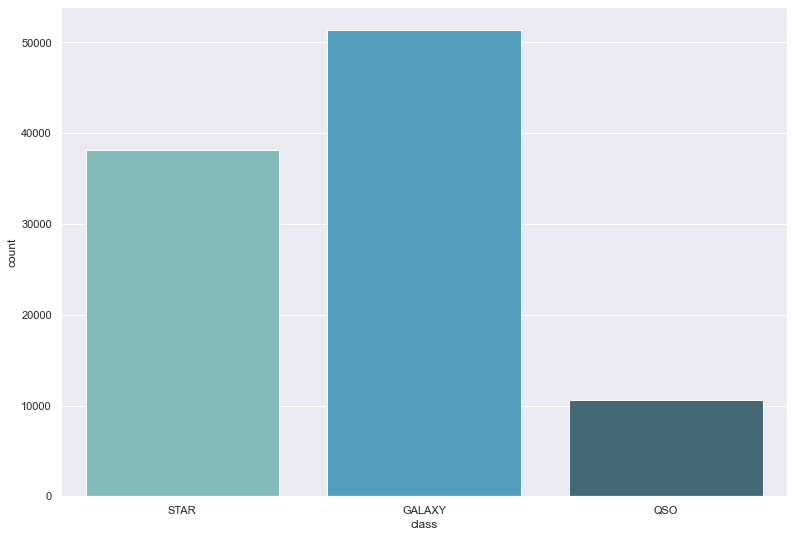

In [10]:
color_palette = 'GnBu_d'
sns.set()
fig = plt.gcf()
fig.set_size_inches(13,9)
sns.countplot(df_features['class'], palette=color_palette)
plt.show()

<AxesSubplot:xlabel='class', ylabel='mjd'>

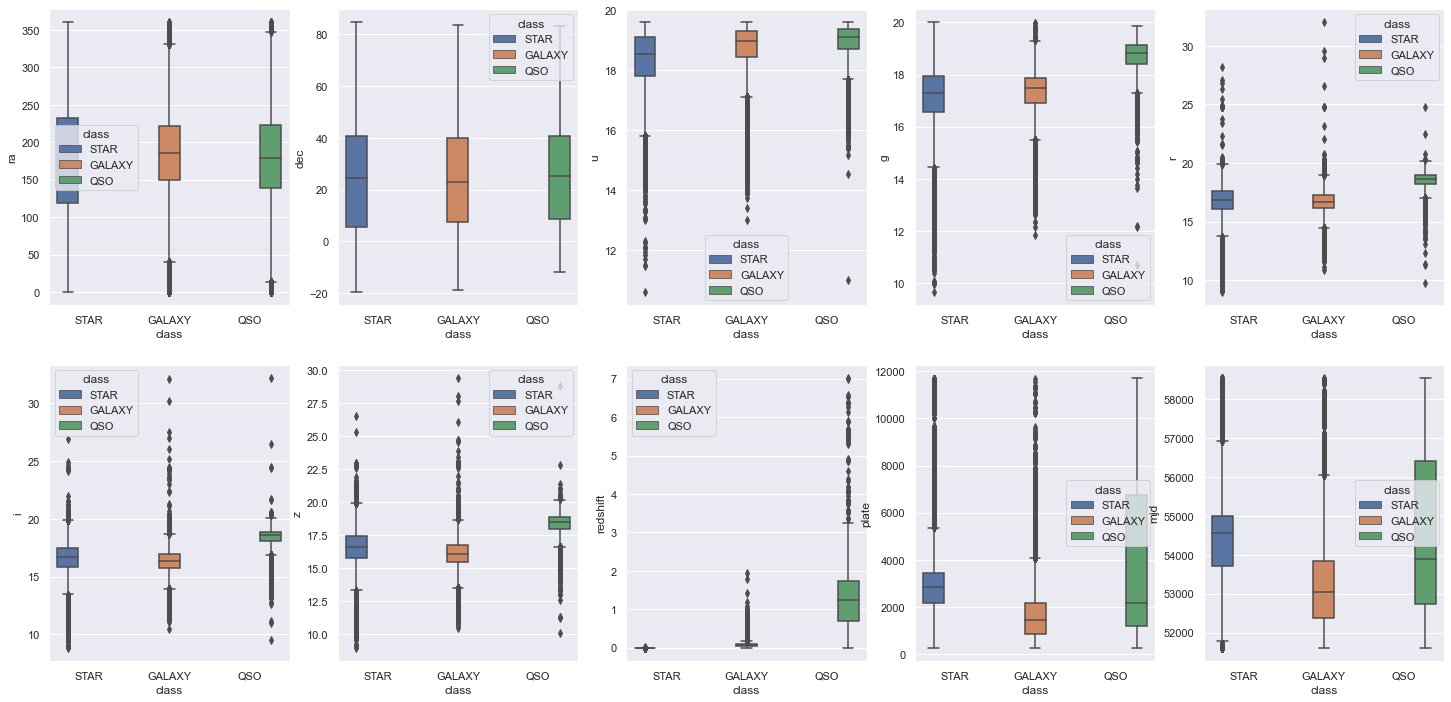

In [11]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(nrows = 2, ncols = 5,
                                                                      figsize = (25,12))


sns.boxplot(ax = ax1, x = 'class', y = 'ra', hue = 'class', data = df_features)
sns.boxplot(ax = ax2, x = 'class', y = 'dec', hue = 'class', data = df_features)
sns.boxplot(ax = ax3, x = 'class', y = 'u', hue = 'class', data = df_features)
sns.boxplot(ax = ax4, x = 'class', y = 'g', hue = 'class', data = df_features)
sns.boxplot(ax = ax5, x = 'class', y = 'r', hue = 'class', data = df_features)
sns.boxplot(ax = ax6, x = 'class', y = 'i', hue = 'class', data = df_features)
sns.boxplot(ax = ax7, x = 'class', y = 'z', hue = 'class', data = df_features)
sns.boxplot(ax = ax8, x = 'class', y = 'redshift', hue = 'class', data = df_features)
sns.boxplot(ax = ax9, x = 'class', y = 'plate', hue = 'class', data = df_features)
sns.boxplot(ax = ax10, x = 'class', y = 'mjd', hue = 'class', data = df_features)

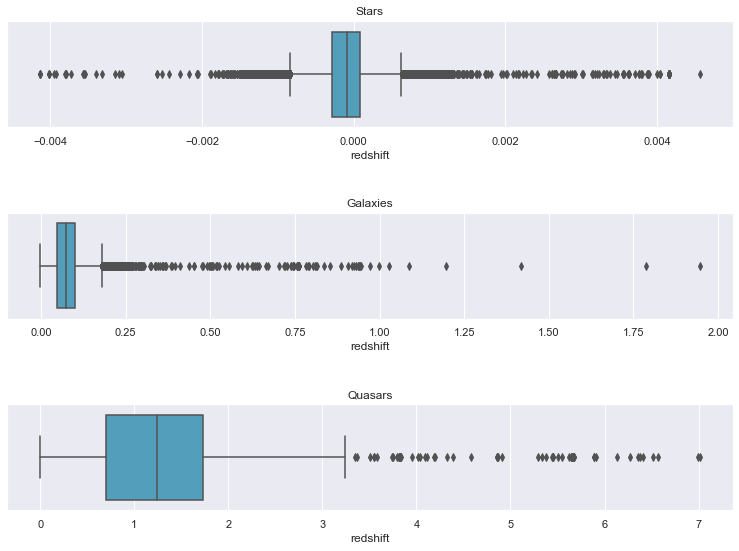

In [12]:
sns.set(style='darkgrid')
fig, axs = plt.subplots(nrows=3)
fig = plt.gcf()
fig.set_size_inches(13,9)
plt.subplots_adjust(hspace=0.8)
sns.boxplot(stars['redshift'], palette=color_palette, ax=axs[0]).set_title('Stars')
sns.boxplot(galaxies['redshift'], palette=color_palette, ax=axs[1]).set_title('Galaxies')
sns.boxplot(quasars['redshift'], palette=color_palette, ax=axs[2]).set_title('Quasars')
plt.show()

# Pairplot

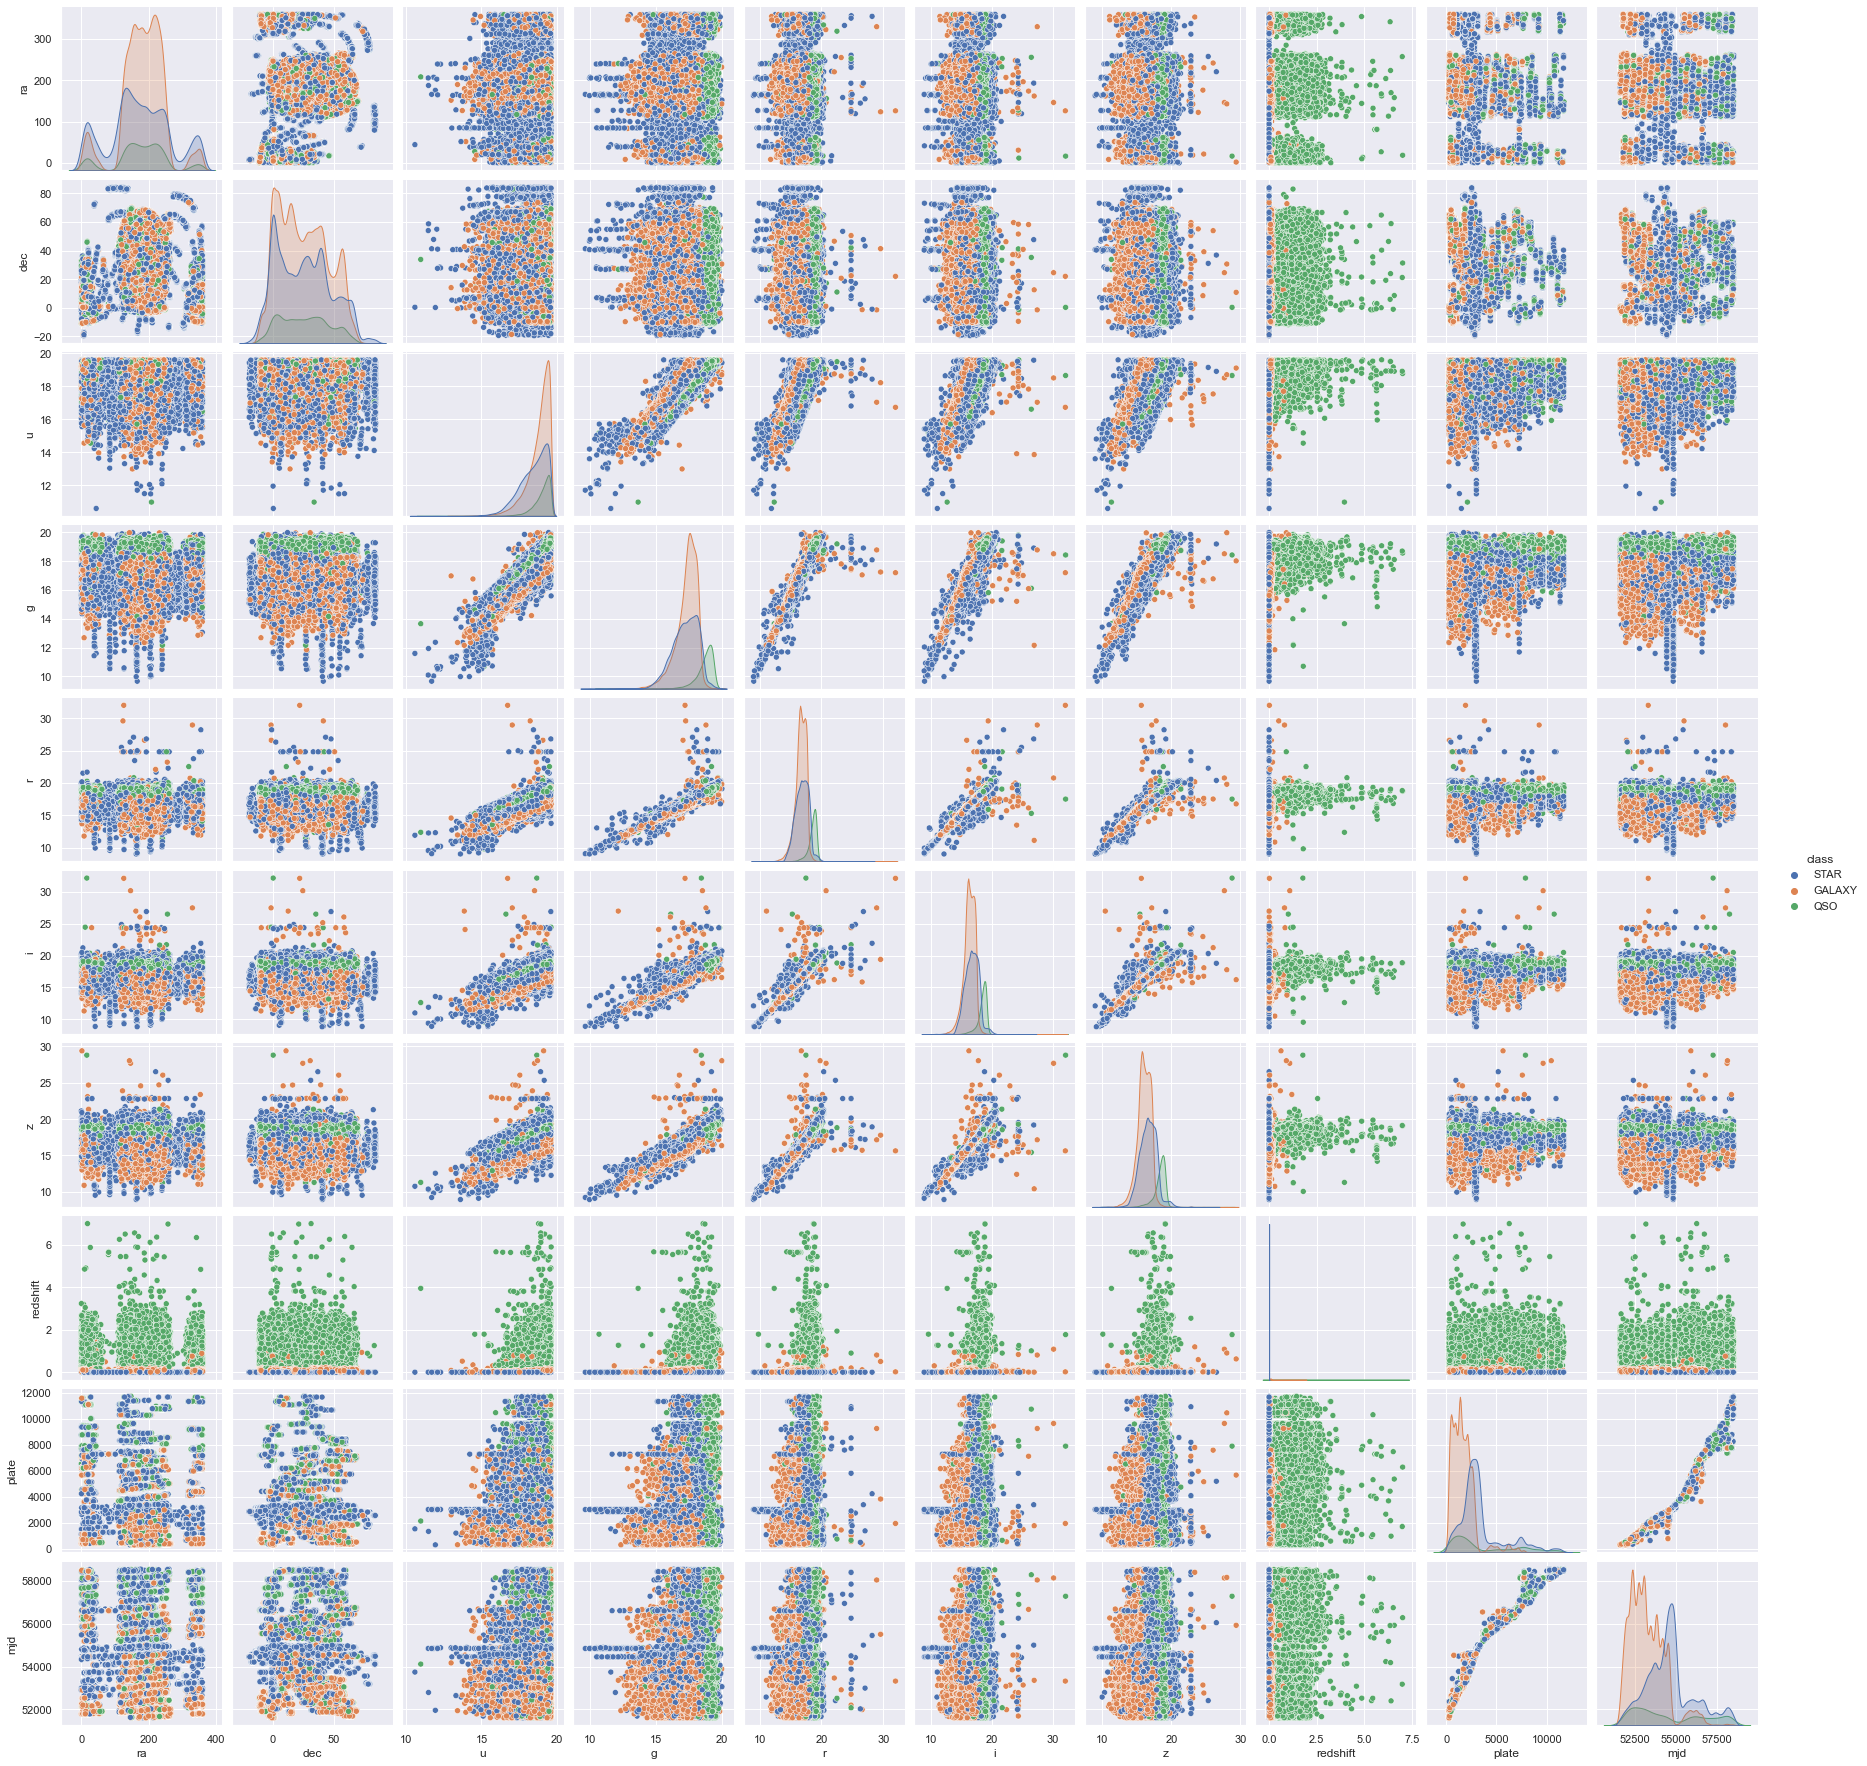

In [13]:
sns.set(style='darkgrid')
sns.pairplot(df_features, hue='class')
plt.show()

# Heatmap

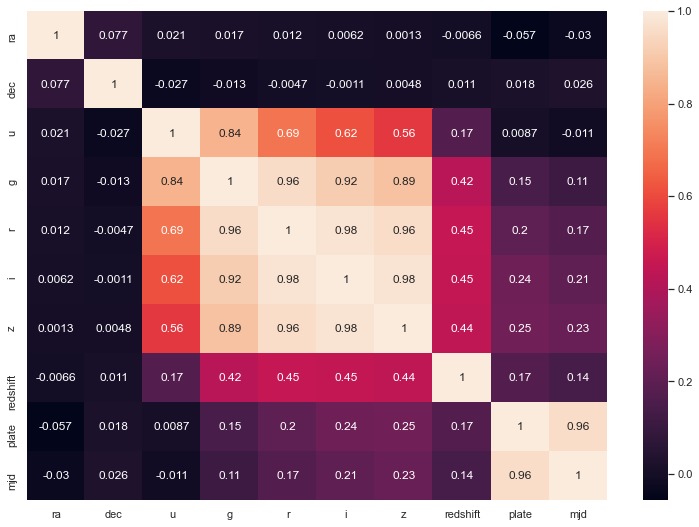

In [14]:
df_features_corr = df_features.corr()
fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(df_features_corr, annot=True)
plt.show()

In [15]:
df_data = df_features[['u','g','r','i','z','redshift']]
df_target = pd.factorize(df_features['class'])[0]
xtrain, xtest, ytrain, ytest = train_test_split(df_data, df_target, test_size=0.30, random_state=0)

Classification Test Score: 0.9677666666666667 

Classification Performance:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     11408
           1       0.98      0.96      0.97     15393
           2       0.97      0.94      0.96      3199

    accuracy                           0.97     30000
   macro avg       0.97      0.96      0.96     30000
weighted avg       0.97      0.97      0.97     30000
 

Train Score: 0.9688857142857142


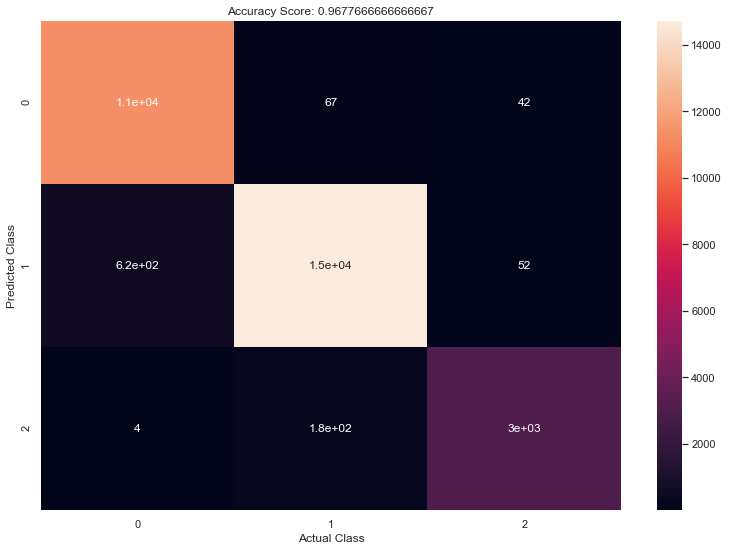

In [16]:
logreg = LogisticRegression(max_iter=350)

logreg.fit(xtrain, ytrain)
ypred = logreg.predict(xtest)

accuracy = logreg.score(xtest, ytest)

print('Classification Test Score:', accuracy ,'\n')
print('Classification Performance:\n', classification_report(ytest, ypred),'\n')
print('Train Score:', logreg.score(xtrain,ytrain))

cm = confusion_matrix(ytest, ypred)

fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(cm, annot=True).set_title('Accuracy Score: {}'.format(accuracy))
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

plt.show()

In [17]:
accuracy=[]
def mymodel(model):
    model.fit(xtrain,ytrain)
    ypred=model.predict(xtest)
    ac=accuracy_score(ytest,ypred)
    accuracy.append(ac)
    print(f"{classification_report(ytest,ypred)}")
    print('Confusion Matrix: \n', confusion_matrix(ytest, ypred))

logreg=LogisticRegression()
knn=KNeighborsClassifier()
svm=SVC()
dt=DecisionTreeClassifier()
rf=RandomForestClassifier()

In [18]:
mymodel(logreg)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     11408
           1       0.97      0.96      0.97     15393
           2       0.95      0.96      0.96      3199

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000

Confusion Matrix: 
 [[11063   279    66]
 [  519 14781    93]
 [    5   120  3074]]


In [19]:
mymodel(knn)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11408
           1       0.97      0.95      0.96     15393
           2       0.98      0.95      0.97      3199

    accuracy                           0.96     30000
   macro avg       0.97      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000

Confusion Matrix: 
 [[11134   259    15]
 [  686 14667    40]
 [   11   137  3051]]


In [20]:
mymodel(dt)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11408
           1       0.99      0.99      0.99     15393
           2       0.95      0.95      0.95      3199

    accuracy                           0.99     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[11379    28     1]
 [   21 15216   156]
 [    3   142  3054]]


In [21]:
mymodel(rf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11408
           1       0.99      1.00      0.99     15393
           2       0.98      0.95      0.97      3199

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.99     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[11387    21     0]
 [   18 15321    54]
 [    3   157  3039]]


In [22]:
bg = BaggingClassifier(LogisticRegression())
bg.fit(xtrain, ytrain)
ypred = bg.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11408
           1       0.98      0.95      0.97     15393
           2       0.96      0.95      0.96      3199

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000



In [23]:
ada = AdaBoostClassifier(n_estimators=50)
ada.fit(xtrain, ytrain)
ypred = ada.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11408
           1       0.83      0.99      0.90     15393
           2       0.67      0.00      0.00      3199

    accuracy                           0.89     30000
   macro avg       0.83      0.66      0.63     30000
weighted avg       0.87      0.89      0.84     30000



In [24]:
gbc = GradientBoostingClassifier(n_estimators=50)
gbc.fit(xtrain, ytrain)
ypred = gbc.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11408
           1       0.99      0.99      0.99     15393
           2       0.98      0.94      0.96      3199

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000



In [25]:
xgb = XGBClassifier()
mymodel(xgb)

[23:50:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11408
           1       0.99      1.00      0.99     15393
           2       0.98      0.96      0.97      3199

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.99     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[11400     8     0]
 [   14 15328    51]
 [    2   137  3060]]


In [26]:
accuracy=[]
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(xtrain, ytrain)
    ypred = knn.predict(xtest)
    accuracy.append(accuracy_score(ytest, ypred))

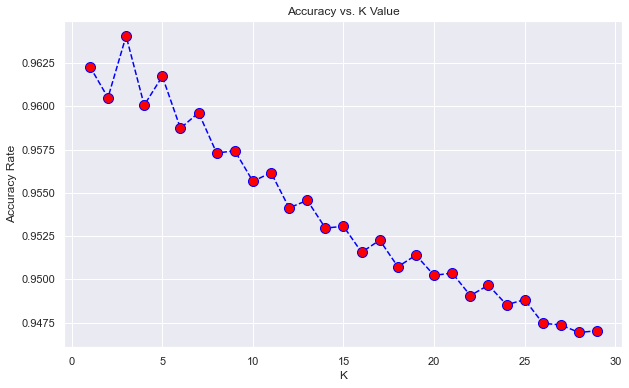

In [27]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30), accuracy, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')
plt.grid(True)
plt.show()

In [28]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain,ytrain)
ypred=knn.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     11408
           1       0.98      0.96      0.97     15393
           2       0.98      0.96      0.97      3199

    accuracy                           0.96     30000
   macro avg       0.97      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000



# Comparision of Actual & Predicted values

In [30]:
data = {'Actual': ytest,'Predicted':ypred}

df1 = pd.DataFrame(data, columns = ['Actual', 'Predicted'])

print (df1)

       Actual  Predicted
0           1          1
1           1          1
2           1          1
3           1          1
4           1          1
...       ...        ...
29995       0          0
29996       1          1
29997       1          1
29998       2          2
29999       2          2

[30000 rows x 2 columns]
